# Human's emotion recognition using thermal images
## *TEACHER: NGUYEN VIET HUNG*
## *MEMBER*
- Vuong Le Minh Nguyen
- Luong Cong Tam

#### Import Library & Settings

In [1]:
import pandas as pd
import sklearn
import scipy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import random
import IPython.display as display
from configparser import ConfigParser
from time import sleep

np.set_printoptions(threshold=np.inf) # Setting for full numpy matrices printin

In [2]:
# Load db config:
dbconfig = ConfigParser()
dbconfig.read('database.ini')

# Assign dbDir with local config:
dbDir = dbconfig['LOCAL']['location'] #Database directory
eDir = {
    "angry":"anger",
    "fear":"fear",
    "happy":"happy",
    "sad":"sadness",
    "neutral":"neutral"
} #Name of directory of each Emotion

#### Function definition

In [3]:
def frameShow(frame):
    w, h = frame.shape
    ret = cv2.imencode('.jpeg',frame)[1]
    i = display.Image(data=ret, width = w, height = h)
    display.display(i)
    sleep(0.05)
#     display.clear_output(True)

In [4]:
def getSVXFiles(fd):
    return glob.glob(fd + '/*.svx') + glob.glob(fd + '/*.SVX')

In [5]:
def getTROIs(frame):
    Tmax = np.amax(frame)
    Tmin = np.amin(frame)
    
    # Map current frame to 8-bit grayscale:
    lbound = np.floor(Tmin)
    rbound = np.ceil(Tmax)
#     grayImg = ((frame-lbound)*256/(rbound-lbound)).astype(int)
    grayImg = (frame*256/rbound).astype(int)
    frameShow(grayImg)
    
    # Get the pixel with the highest intensity in grayscale:
    T_icmgr = np.argmax(np.bincount(np.flatten(grayImg)))
    
    # Calculate delta t:
    deltaT = (Tmax - Tmin)/T_icmgr
#     print(deltaT)
    # Get TROIs:
    TROIs = frame
    for i in range(TROIs.shape[0]):
        for j in range(TROIs.shape[1]):
            if frame[i][j] > Tmax - deltaT * TROIs[i][j] or frame[i][j] < Tmin + deltaT * TROIs[i][j]:
                TROIs[i][j] = 0
    
    return TROIs
    

In [6]:
def getGrayImage(frame, bit_depth = 8):
    Tmax = np.amax(frame)
    Tmin = np.amin(frame)
    
    # Map current frame to 8-bit grayscale:
    lbound = np.floor(Tmin)
    rbound = np.ceil(Tmax)
    scale = 2**bit_depth
    grayImg = ((frame-lbound)*scale/(rbound-lbound)).astype(np.uint8)
    
    return grayImg

In [7]:
def getFace(frame, minTemp = 30.0, fitEllipsePoint = 50):
    xFrame, yFrame = frame.shape
    topEdge, rightEdge, bottomEdge, leftEdge = xFrame, 0, 0, yFrame
    ret = np.copy(frame) # Do not change anythings in input array
    
    for x in range(xFrame):
        for y in range(yFrame):
            if (ret[x][y] < minTemp):
                ret[x][y] = 5
            else:
                topEdge = min(topEdge, x)
                rightEdge = max(rightEdge, y)
                bottomEdge = max(bottomEdge, x)
                if x <= xFrame/2:
                    leftEdge = min(leftEdge, y)            
                    
    topEdge = max(topEdge - 10, 0)
    leftEdge = max(leftEdge -10, 0)
    rightEdge = leftEdge+190 #TODO: Change this hardcode to auto determint right Edge
    bottomEdge = min(topEdge + 220, xFrame) # May be this is find with hard coded :))
    
#     sliced = np.uint8(ret[topEdge:topEdge+faceBox[0], leftEdge:leftEdge+faceBox[1]])
#     sliced = np.uint8(ret)
    gray = getGrayImage(ret[topEdge:bottomEdge, leftEdge:rightEdge])

    blured = cv2.GaussianBlur(gray.copy(),(5,5),1)
    cannied = cv2.Canny(blured,20,80)
    
    kernelSize = (20,10)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,kernelSize)
    cannied = cv2.dilate(cannied, kernel)
    
    _, contours, hierarchy = cv2.findContours(cannied, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    drawedContours = cv2.drawContours(blured,contours,-1,(255,0,0), 1)
    
    minEllipse = [None]*len(contours)
    
    for i, c in enumerate(contours):
        if c.shape[0]>fitEllipsePoint and hierarchy[0, i, 3] == -1:
            minEllipse[i] = cv2.fitEllipse(c)
            
    drawing = np.zeros((gray.shape[0], gray.shape[1], 3), dtype=np.uint8)
    mask = drawing.copy()
    for i, c in enumerate(contours):
        color = (255, 255, 255)
        if c.shape[0]>fitEllipsePoint and hierarchy[0, i, 3] == -1:
            cv2.ellipse(drawing, minEllipse[i], color, 2)
            cv2.ellipse(mask, minEllipse[i], color, -1)
        cv2.drawContours(drawing, contours, i, color)
    
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    face = cv2.bitwise_and(gray, mask)
    
#     plt.subplot(121)
#     plt.imshow(gray)

#     plt.subplot(122)
#     plt.imshow(drawing)
    
#     plt.show()
    
#     plt.subplot(121)
#     plt.imshow(mask)
#     plt.subplot(122)
#     plt.imshow(cropped)
    
#     plt.show()
    
    return face

In [12]:
def readIntensitiesFromSVX(file, frame_start = 0, frame_limit = 6990):
    # Default frame_limit is based on the requirement of at least 1GB of free RAM (6990*153600B ~~ 1GB)
    # Open file to read:
    f = open(file,'rb') 
    
    # Skip 128 bytes from the file's beginning:
    f.seek(128) 
    
    # Calculate temperature converter:
    [CA,CB] = np.divide(np.frombuffer(f.read(8), dtype=np.dtype('<i4'), count=2), 2**16)
    #Array from buffer
    #Data type: int32 (4 bytes/each - 'i4') 
    #Byte-order:  Litte-endian ('<')
    
    # Skip to the beginning of first frame to start reading:
    f.seek(1104)
    
    # Skip to frame_start:
    f.seek(frame_start*(153600+2592), 1)
    
    intensities = []

    for i in range (0,frame_limit):
        buffer = f.read(153600)
        
        # Check EOF:
        if len(buffer) < 153600:
            break
        
        img = np.frombuffer(buffer,dtype=np.dtype('>i2'))
        #Array from buffer
        #Data type: int16 (2 bytes/each - 'i2') 
        #Byte-order:  Big-endian ('>')
        
        # Convert read img to temperature, then reshape from 1D to 2D, then convert it to grayscale and get Face Thermal Matrix:
        face = getFace((img * CB + CA).reshape(240,320))
        
        # Get grayscale intensity of current face:
        intensity = np.bincount(face.flatten(), minlength = 256)
        intensity[0] = 0 # remove all zero-meaning pixels
        intensity = (intensity / np.sum(intensity)).tolist()
        
        # Add loaded intensity to the result array:
        intensities.append(intensity[180:256])
        
#         print('frame:',i)
#         display.clear_output(True)
        
        # Move to the beginning of next frame to continue reading:
        f.seek(2592,1) 
    
    f.close()
    return intensities

#### Observe dataset

Loaded file ./dataset/anger/chinha2.svx
Loaded file ./dataset/anger/Nhatangry1.svx
Loaded file ./dataset/anger/quana1.svx
Loaded file ./dataset/anger/vieta1.svx
Loaded file ./dataset/anger/Nama1.svx
Loaded file ./dataset/anger/LamA1.svx
Loaded file ./dataset/anger/nhata1.svx
Loaded file ./dataset/anger/cuonga1.svx
Loaded file ./dataset/anger/anan1.svx
Loaded file ./dataset/anger/thoa1.SVX
Loaded file ./dataset/anger/maya1vx.SVX
Loaded file ./dataset/anger/nguyetanger1.SVX
Loaded file ./dataset/anger/thaoa1.SVX
Loaded file ./dataset/anger/khanha2.SVX
Finished loading ANGRY
Loaded file ./dataset/fear/nhats2.svx
Loaded file ./dataset/fear/Nhuts2.svx
Loaded file ./dataset/fear/nghias2.svx
Loaded file ./dataset/fear/duys4 bonus.svx
Loaded file ./dataset/fear/Nams5.svx
Loaded file ./dataset/fear/thiens4.svx
Loaded file ./dataset/fear/Huongs1.svx
Loaded file ./dataset/fear/viets2.svx
Loaded file ./dataset/fear/ans2.svx
Loaded file ./dataset/fear/quyens2.svx
Loaded file ./dataset/fear/thanhs2.

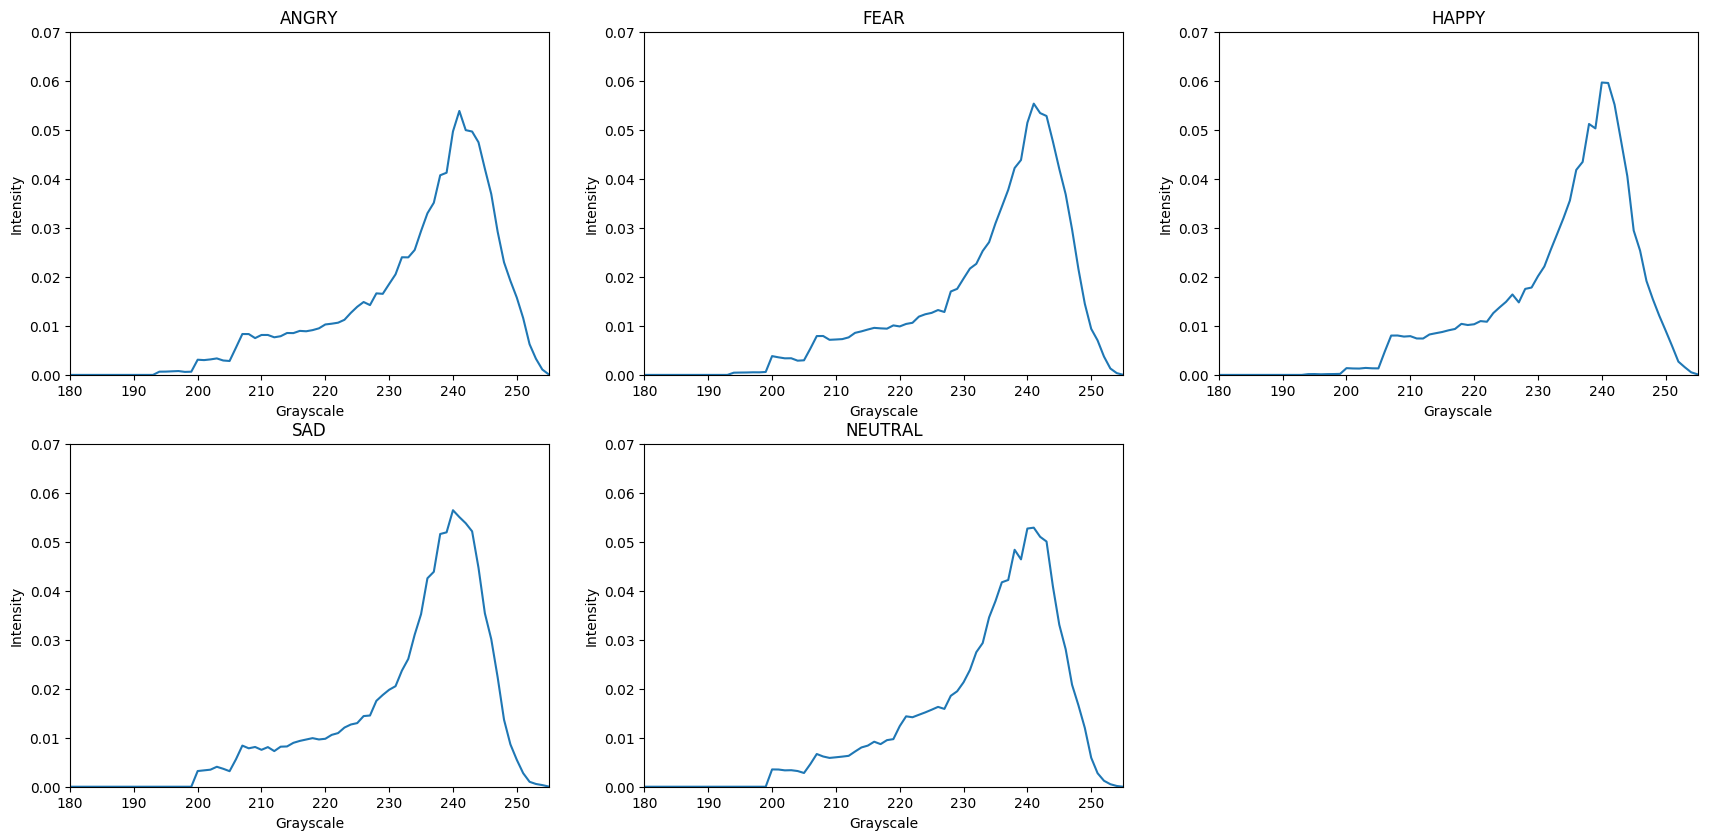

In [37]:
# Observe the dataset:
train = dict()
plotIndex = 1
plt.figure(num=None,figsize=(21,10),dpi=100)
for e in eDir:
    eIntensities = []
    for file in getSVXFiles(dbDir+eDir[e]):
#         frameShow(face)
        eIntensities.extend(readIntensitiesFromSVX(file, frame_limit = 1))
        print('Loaded file', file)
    train[e] = np.average(eIntensities, axis = 0)
    print('Finished loading',e.upper())
#     print(e, train[e])
    plt.subplot(2, 3, plotIndex)
#     plt.bar(np.arange(256), train[e], align = 'center', alpha = 0.5, width = 1)
    plt.plot(np.arange(180, 256), train[e], alpha = 1)
    plt.axis([180, 255, 0, 0.07])
    plt.xlabel('Grayscale')
    plt.ylabel('Intensity')
    plt.title(e.upper())
    plotIndex += 1
    
# plt.tight_layout()
plt.show()

#### Convert raw thermal images from svx to intensities for training and testing model

In [10]:
def getDataFrameFromSVXs(dbLocation):
    eIntensities = []
    for e in eDir:
        for file in getSVXFiles(dbDir+eDir[e]):
            # Get rows of features:
            rows = readIntensitiesFromSVX(file, frame_limit = 20000)
            # Get label for each row:
            for row in rows:
                row.append(e)
            eIntensities.extend(rows)
            print('Loaded file', file)
        
        print('Finished loading',e.upper())
    return pd.DataFrame(eIntensities, columns = list(map(str, range(180,256))) + ['Emotion'])

In [13]:
# getDataFrameFromSVXs(dbDir).to_csv('./GrayscaleIntensities/intensities.csv', index = False)
# print("Finished exporting data to csv")

Loaded file ./dataset/anger/chinha2.svx
Loaded file ./dataset/anger/Nhatangry1.svx
Loaded file ./dataset/anger/quana1.svx
Loaded file ./dataset/anger/vieta1.svx
Loaded file ./dataset/anger/Nama1.svx
Loaded file ./dataset/anger/LamA1.svx
Loaded file ./dataset/anger/nhata1.svx
Loaded file ./dataset/anger/cuonga1.svx
Loaded file ./dataset/anger/anan1.svx
Loaded file ./dataset/anger/thoa1.SVX
Loaded file ./dataset/anger/maya1vx.SVX
Loaded file ./dataset/anger/nguyetanger1.SVX
Loaded file ./dataset/anger/thaoa1.SVX
Loaded file ./dataset/anger/khanha2.SVX
Finished loading ANGRY
Loaded file ./dataset/fear/nhats2.svx
Loaded file ./dataset/fear/Nhuts2.svx
Loaded file ./dataset/fear/nghias2.svx
Loaded file ./dataset/fear/duys4 bonus.svx
Loaded file ./dataset/fear/Nams5.svx
Loaded file ./dataset/fear/thiens4.svx
Loaded file ./dataset/fear/Huongs1.svx
Loaded file ./dataset/fear/viets2.svx
Loaded file ./dataset/fear/ans2.svx
Loaded file ./dataset/fear/quyens2.svx
Loaded file ./dataset/fear/thanhs2.

#### Load data from csv

In [33]:
data = pd.read_csv('./GrayscaleIntensities/intensities.csv')
data.head()

,180,181,182,183,184,185,186,187,188,189,...,247,248,249,250,251,252,253,254,255,Emotion
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028320,0.026284,0.019029,0.009355,0.007255,0.002100,0.000064,0.0,0.0,angry
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028662,0.024866,0.021322,0.009174,0.006327,0.002657,0.000127,0.0,0.0,angry
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028335,0.024587,0.018170,0.010102,0.006480,0.002668,0.000000,0.0,0.0,angry
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.026796,0.025176,0.017137,0.010532,0.004861,0.002493,0.000125,0.0,0.0,angry
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025483,0.020081,0.017603,0.007816,0.003622,0.001462,0.000064,0.0,0.0,angry


#### Train-Test split

In [35]:
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(data, test_size = 0.25, random_state = 1, shuffle = True)
# train.to_csv('./GrayscaleIntensities/train.csv', index = False)
# test.to_csv('./GrayscaleIntensities/test.csv', index = False)

#### Load train and test from csv

In [38]:
train = pd.read_csv('./GrayscaleIntensities/train.csv')
test = pd.read_csv('./GrayscaleIntensities/test.csv')